In [ ]:
import numpy as np
import plotly.graph_objects as go

from IPython.display import Image

Measurements:

In [ ]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y = np.array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1])

Basic stats:

In [ ]:
num_zeros = (1 - y).sum()
num_ones = y.sum()
freq_of_ones = y.mean()

Standard definitions:

In [ ]:
def logit(p: np.ndarray) -> np.ndarray:
    return np.log(p / (1 - p))


def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

Plotly helpers:

In [ ]:
def rasterize(fig: go.Figure, **kwargs) -> Image:
    return Image(fig.to_image(**kwargs))

def add_sigmoid(fig: go.Figure, w: float, b: float, name: str) -> None:
    fig.add_trace(
        go.Scatter(x=x_plot, y=sigmoid(w * x_plot + b), mode="lines", name=name)
    )

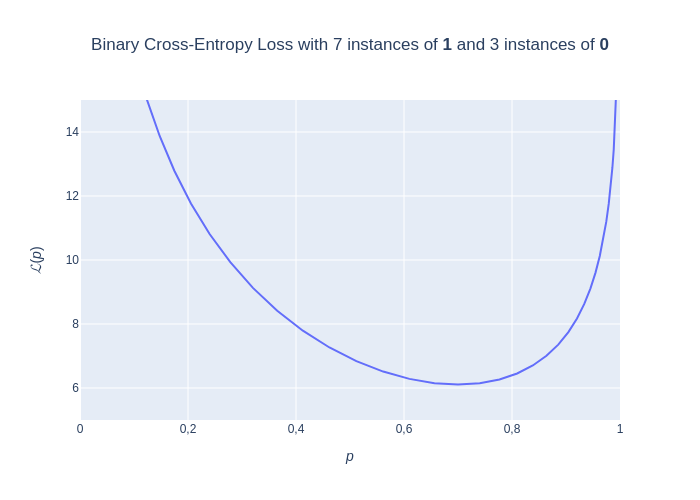

In [ ]:
x_plot = sigmoid(logit(freq_of_ones) + np.linspace(-6, 11, num=1 + 5 * (11 + 6)))
y_plot = -(y.sum() * np.log(x_plot) + (1 - y).sum() * np.log(1-x_plot))

fig = go.FigureWidget()
fig.add_trace(go.Scatter(x=x_plot, y=y_plot, mode="lines"))
fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[5, 15])
fig.update_layout(
    title=f"Binary Cross-Entropy Loss with {num_ones} instances of "
    f"<b>1</b> and {num_zeros} instances of <b>0</b>",
    xaxis_title=r"<i>p</i>",
    yaxis_title="<i>ℒ</i>(<i>p</i>)",
)
fig.write_json("bce_7_3.json")
rasterize(fig)

Define Numpy-compatible loss functions for minimization:

In [ ]:
def logistic_regression_bce_loss(w_and_b: np.ndarray) -> float:
    w, b = w_and_b
    yhat = sigmoid(w * x + b)
    individual_losses = -(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
    cumulative_loss = individual_losses.sum()
    return cumulative_loss

def logistic_regression_mse_loss(w_and_b: np.ndarray) -> float:
    w, b = w_and_b
    yhat = sigmoid(w * x + b)
    individual_losses = (y - yhat) ** 2
    cumulative_loss = individual_losses.sum()
    return cumulative_loss

Plot losses:

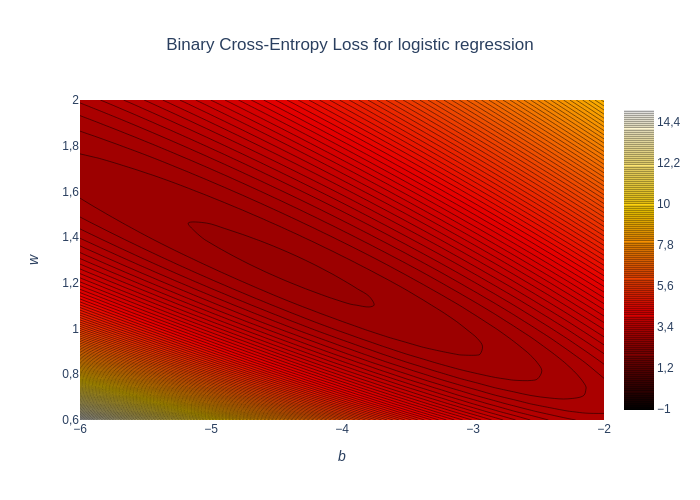

In [ ]:
w_plot = np.linspace(0.6, 2, num=40)
b_plot = np.linspace(-6, -2, num=30)

loss_grid = np.array(
    [[logistic_regression_bce_loss(np.array([w, b])) for b in b_plot] for w in w_plot]
)

fig = go.FigureWidget()
fig.add_trace(
    go.Contour(
        x=b_plot,
        y=w_plot,
        z=loss_grid,
        contours=dict(start=-1, end=15, size=0.11),
        colorscale="Hot",
        hovertemplate = '<i>b</i>=%{x}<br><i>w</i>=%{y}<br>ℒ=%{z}<extra></extra>'
    )
)
fig.update_layout(
    title="Binary Cross-Entropy Loss for logistic regression",
    xaxis_title=r"<i>b</i>",
    yaxis_title="<i>w</i>",
)
fig.write_json("bce_logistic.json")
rasterize(fig)

Compute minima of losses

In [ ]:
from scipy.optimize import minimize

w_init, b_init = 0, 0
w_mse_opt, b_mse_opt = minimize(logistic_regression_mse_loss, (w_init, b_init)).x
w_bce_opt, b_bce_opt = minimize(logistic_regression_bce_loss, (w_init, b_init)).x
print(w_mse_opt, b_mse_opt)
print(w_bce_opt, b_bce_opt)

0.9091985081276 -3.171384962265439
1.2674642132740959 -4.415117673819803


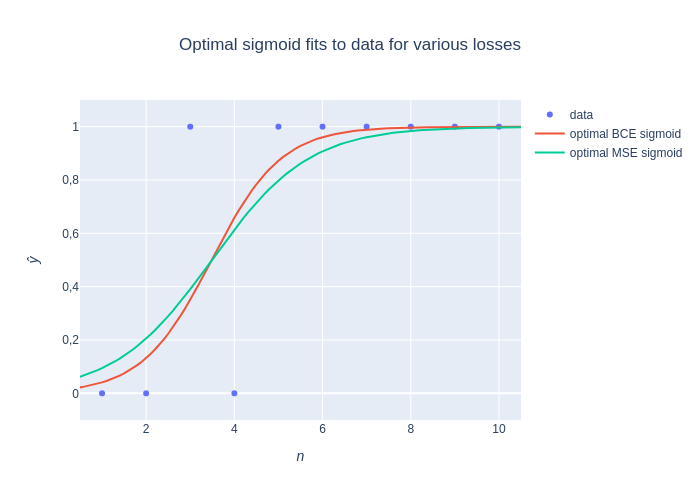

In [ ]:
fig = go.FigureWidget()
fig.add_trace(go.Scatter(x=x, y=y, mode="markers", name="data"))
fig.update_xaxes(range=[0.5, 10.5])
fig.update_yaxes(range=[-0.1, 1.1])

x_plot = np.linspace(0, 11, num=111)
add_sigmoid(fig, w=w_bce_opt, b=b_bce_opt, name="optimal BCE sigmoid")
add_sigmoid(fig, w=w_mse_opt, b=b_mse_opt, name="optimal MSE sigmoid")

fig.update_layout(
    title="Optimal sigmoid fits to data for various losses",
    xaxis_title=r"<i>n</i>",
    yaxis_title="<i>ŷ</i>",
)
fig.write_json("best_sigmoids.json")
rasterize(fig)

Run a simulation to estimate the success rate for BCE and MSE parameters:

In [ ]:
n_trials = 10_000_000
rng = np.random.default_rng(seed=0)

for w, b, name in [(w_bce_opt, b_bce_opt, "BCE"), (w_mse_opt, b_mse_opt, "MSE")]:

    sigmoid_probs = sigmoid(w * x + b)
    correct_probs = sigmoid_probs * y + (1 - sigmoid_probs) * (1 - y)

    measured_rate = np.all(
        rng.random(size=(n_trials, 10)) < np.tile(correct_probs, (n_trials, 1)),
        axis=1,
    ).mean()

    theoretical_rate = np.exp(-logistic_regression_bce_loss(np.array([w, b])))

    print(f"   Measured {name} success rate: {measured_rate:.3%}")
    print(f"Theoretical {name} success rate: {theoretical_rate:.3%}")

   Measured BCE success rate: 8.252%
Theoretical BCE success rate: 8.243%
   Measured MSE success rate: 7.343%
Theoretical MSE success rate: 7.357%


Plot success probability:

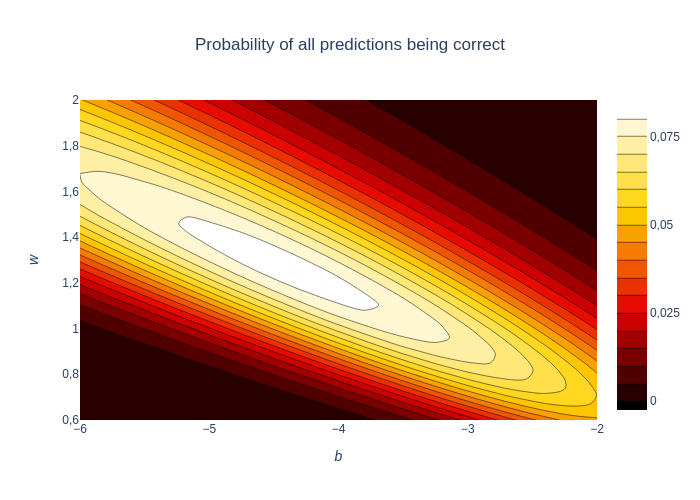

In [ ]:
# I'm cheating here because I know it's correct,
# and don't feel like implementing the product...
loss_grid = np.exp(
    -np.array(
        [
            [logistic_regression_bce_loss(np.array([w, b])) for b in b_plot]
            for w in w_plot
        ]
    )
)

fig = go.FigureWidget()
fig.add_trace(
    go.Contour(
        x=b_plot,
        y=w_plot,
        z=loss_grid,
        contours=dict(start=0, end=0.08243, size=0.005),
        colorscale="Hot",
        hovertemplate="<i>b</i>=%{x}<br><i>w</i>=%{y}<br><i>P</i>(all correct)=%{z}<extra></extra>",
    )
)
fig.update_layout(
    title="Probability of all predictions being correct",
    xaxis_title=r"<i>b</i>",
    yaxis_title="<i>w</i>",
)
fig.write_json("prob_all_correct.json")
rasterize(fig)

Define a Bayesian model

In [ ]:
import pymc3 as pm
import arviz as az

logistic_regression_model = pm.Model()

with logistic_regression_model:
    # Use raw likelihood.
    w = pm.Flat("w")
    b = pm.Flat("b")

    pm.Bernoulli("ŷ", logit_p=w * x + b, observed=y)

Sample from the model

In [ ]:
with logistic_regression_model:
    trace = pm.sample(
        draws=2_000,
        return_inferencedata=True,
        tune=10_000,
        random_seed=0,
        cores=1,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, w]


Sampling 2 chains for 10_000 tune and 2_000 draw iterations (20_000 + 4_000 draws total) took 25 seconds.
The number of effective samples is smaller than 10% for some parameters.


Visualize results

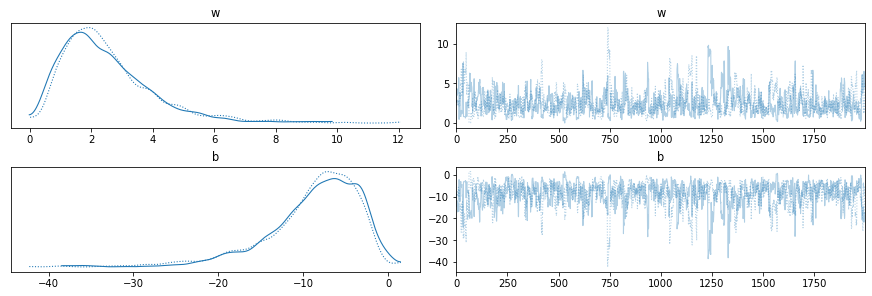

In [ ]:
az.plot_trace(trace);

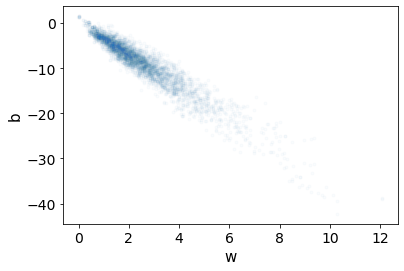

In [ ]:
az.plot_pair(trace, backend="matplotlib", scatter_kwargs=dict(alpha=0.02));

Draw a subsample for plotting

In [ ]:
samples = trace.posterior.to_dataframe().sample(10, random_state=0)
samples

w          b
chain draw                     
1     230   2.456840 -10.611351
0     668   1.642200  -5.525504
1     1616  3.306705 -10.094536
      363   2.956817 -11.738963
0     142   2.781867  -8.119327
      538   0.651409  -2.389235
      1791  1.192934  -2.781312
      410   3.458429 -13.826822
      1150  4.798976 -16.784939
      1032  0.833529  -3.045022

Plot the subsample

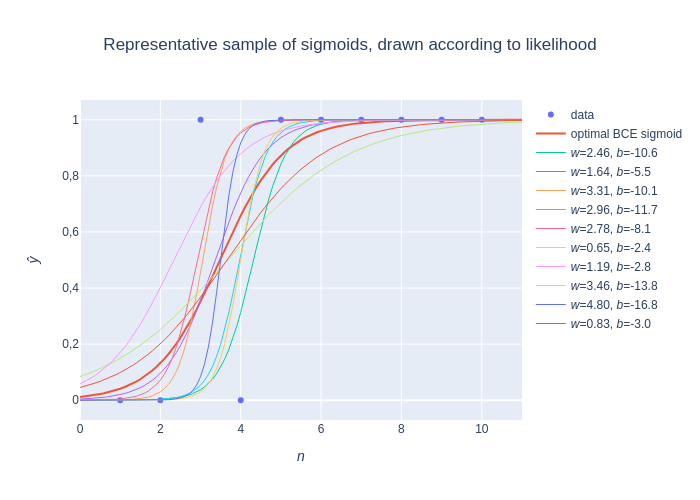

In [ ]:
fig = go.FigureWidget()
fig.add_trace(go.Scatter(x=x, y=y, mode="markers", name="data"))
add_sigmoid(fig, w=w_bce_opt, b=b_bce_opt, name="optimal BCE sigmoid")

x_plot = np.linspace(0, 11, num=111)
for _, sample in samples.iterrows():
    name = f"<i>w</i>={sample.w:.2f}, <i>b</i>={sample.b:.1f}"
    add_sigmoid(fig, w=sample.w, b=sample.b, name=name)
    fig.data[-1].line.width = 1

fig.update_layout(
    title="Representative sample of sigmoids, drawn according to likelihood",
    xaxis_title=r"<i>n</i>",
    yaxis_title="<i>ŷ</i>",
)
fig.write_json("sampled_sigmoids.json")
rasterize(fig)